# **Лабораторна робота №4.2**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Навчання регресiйної моделi градiєнтними методами в TensorFlow"

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt 
import seaborn as sns

import time
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### **Мета роботи:**
* Навчитися створювати моделi згорткових нейронних мереж за допомогою бiблiотеки TensorFlow та API Keras.
* Використати згорткову нейронну мережу для класифiкацiї чорно-бiлих та кольорових зображень.
* Порiвняти результати з результатами на основi моделi MLP.
* Для представлення результатiв використати TensorBoard.

### **Хід виконання роботи:**
1. Завантажити два набори зображень згiдно з варiантом: чорно-бiлi (дивiться попереднiй практикум) та кольоровi. Якщо набiр великого розмiру, можна обрати частину.
1. Пiдготувати данi для навчання - за необхiдностi.
1. Роздiлити данi на навчальну, перевiрочну i тестову пiдмножини.
1. Побудувати i навчити базову модель з одним згортковим шаром. Оцiнити правильнiсть (accuracy) та точнiсть моделi на тренувальнiй i перевiрочнiй множинах.
1. Дослiдити рiзнi значення параметрiв padding i strides згорткового шару базової моделi, а також розмiрнiсть ядра (kernel) згортки та їх вплив на точнiсть моделi. На перевiрочнiй множинi обрати значення вказаних параметрiв.
1. Дослiдити кiлька альтернативних архiтектур згорткових моделей, якi включають:
    * кiлька згорткових шарiв,
    * шар/ шари нормалiзацiї за мiнi-батчами,
    * шар/ шари дропауту.

    На перевiрочнiй множинi оцiнити якiсть побудованих моделей i обрати найкращу архiтектуру. Використати показники якостi: accuracy, precision, recall, f1-score, AUC.

7. Чи впливає на правильнiсть (accuracy) моделi додавання регуляризацiї: дропаут, рання зупинка навчання, та використання рiзних методiв iнiцiалiзацiї ваг?
8. Вiдобразити у TensorBoard графiки, якi iлюструють оцiнки якостi навчання мереж на навчальнiй та перевiрочнiй множинах:
    * графiки змiни функцiї втрат на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделей,
    * графiки змiни правильностi моделi на тренувальнiй i перевiрочнiй множинах по мiрi навчання моделей.
9. Розрахувати на тестовiй множинi оцiнки якостi обраної найкращої моделi.
10. Завантажити зображення тестової множини i розпiзнати його навченими моделями.
11. Порiвняти побудованi згортковi моделi та багатошаровий персептрон в задачi класифiкацiї чорно-бiлих та кольорових зображень.
12. Зробити висновки щодо якостi класифiкацiї на основi побудованих моделей.

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **RGB Dataset:**

In [4]:
IMAGE_SIZE = (224, 224)

## **Data Preprocessing**

In [5]:
df = pd.read_csv('../input/clothing-dataset-full/images.csv')
df = df[df['label'] != 'Skip'].copy()
df['filepath'] = df['image'].apply(
    lambda image: f"../input/clothing-dataset-full/images_compressed/{image}.jpg"
    )

df.head()

image  sender_id     label   kids  \
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False   
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False   
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False   
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False   
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False   

                                            filepath  
0  ../input/clothing-dataset-full/images_compress...  
1  ../input/clothing-dataset-full/images_compress...  
2  ../input/clothing-dataset-full/images_compress...  
3  ../input/clothing-dataset-full/images_compress...  
4  ../input/clothing-dataset-full/images_compress...

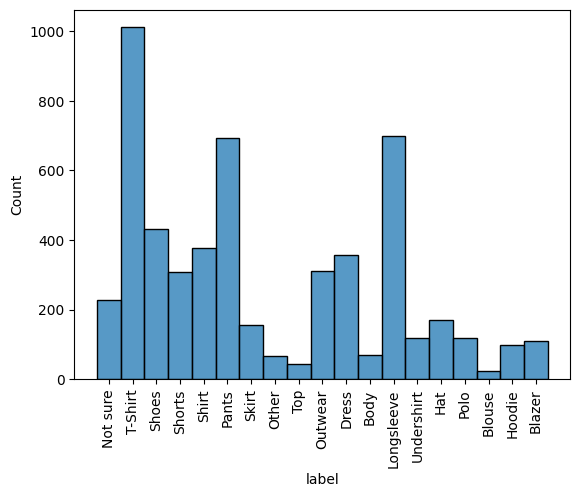

In [6]:
sns.histplot(df["label"])
plt.xticks(rotation=90)
plt.show()

### Split data into train, valid & test

In [7]:
from sklearn.model_selection import train_test_split

train_df, dummy_df = train_test_split(df,
                                      test_size=0.2,
                                      shuffle=True, random_state=42,
                                      stratify= df['label']
                                      )

valid_df, test_df = train_test_split(dummy_df,
                                     test_size=0.5,
                                     shuffle=True, random_state=42,
                                     stratify=dummy_df['label']
                                     )

In [8]:
print(f"Train shape = {train_df.shape}")
print(f"Valid shape = {valid_df.shape}")
print(f"Test shape = {test_df.shape}")

Train shape = (4312, 5)

Valid shape = (539, 5)

Test shape = (540, 5)


#### Image data generator

In [9]:
BATCH_SIZE = 32

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
train_generator = train_generator.flow_from_dataframe(
    train_df, 
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_generator.flow_from_dataframe(
    valid_df,
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = test_generator.flow_from_dataframe(
    test_df, 
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

Found 4311 validated image filenames belonging to 19 classes.

Found 539 validated image filenames belonging to 19 classes.

Found 540 validated image filenames belonging to 19 classes.


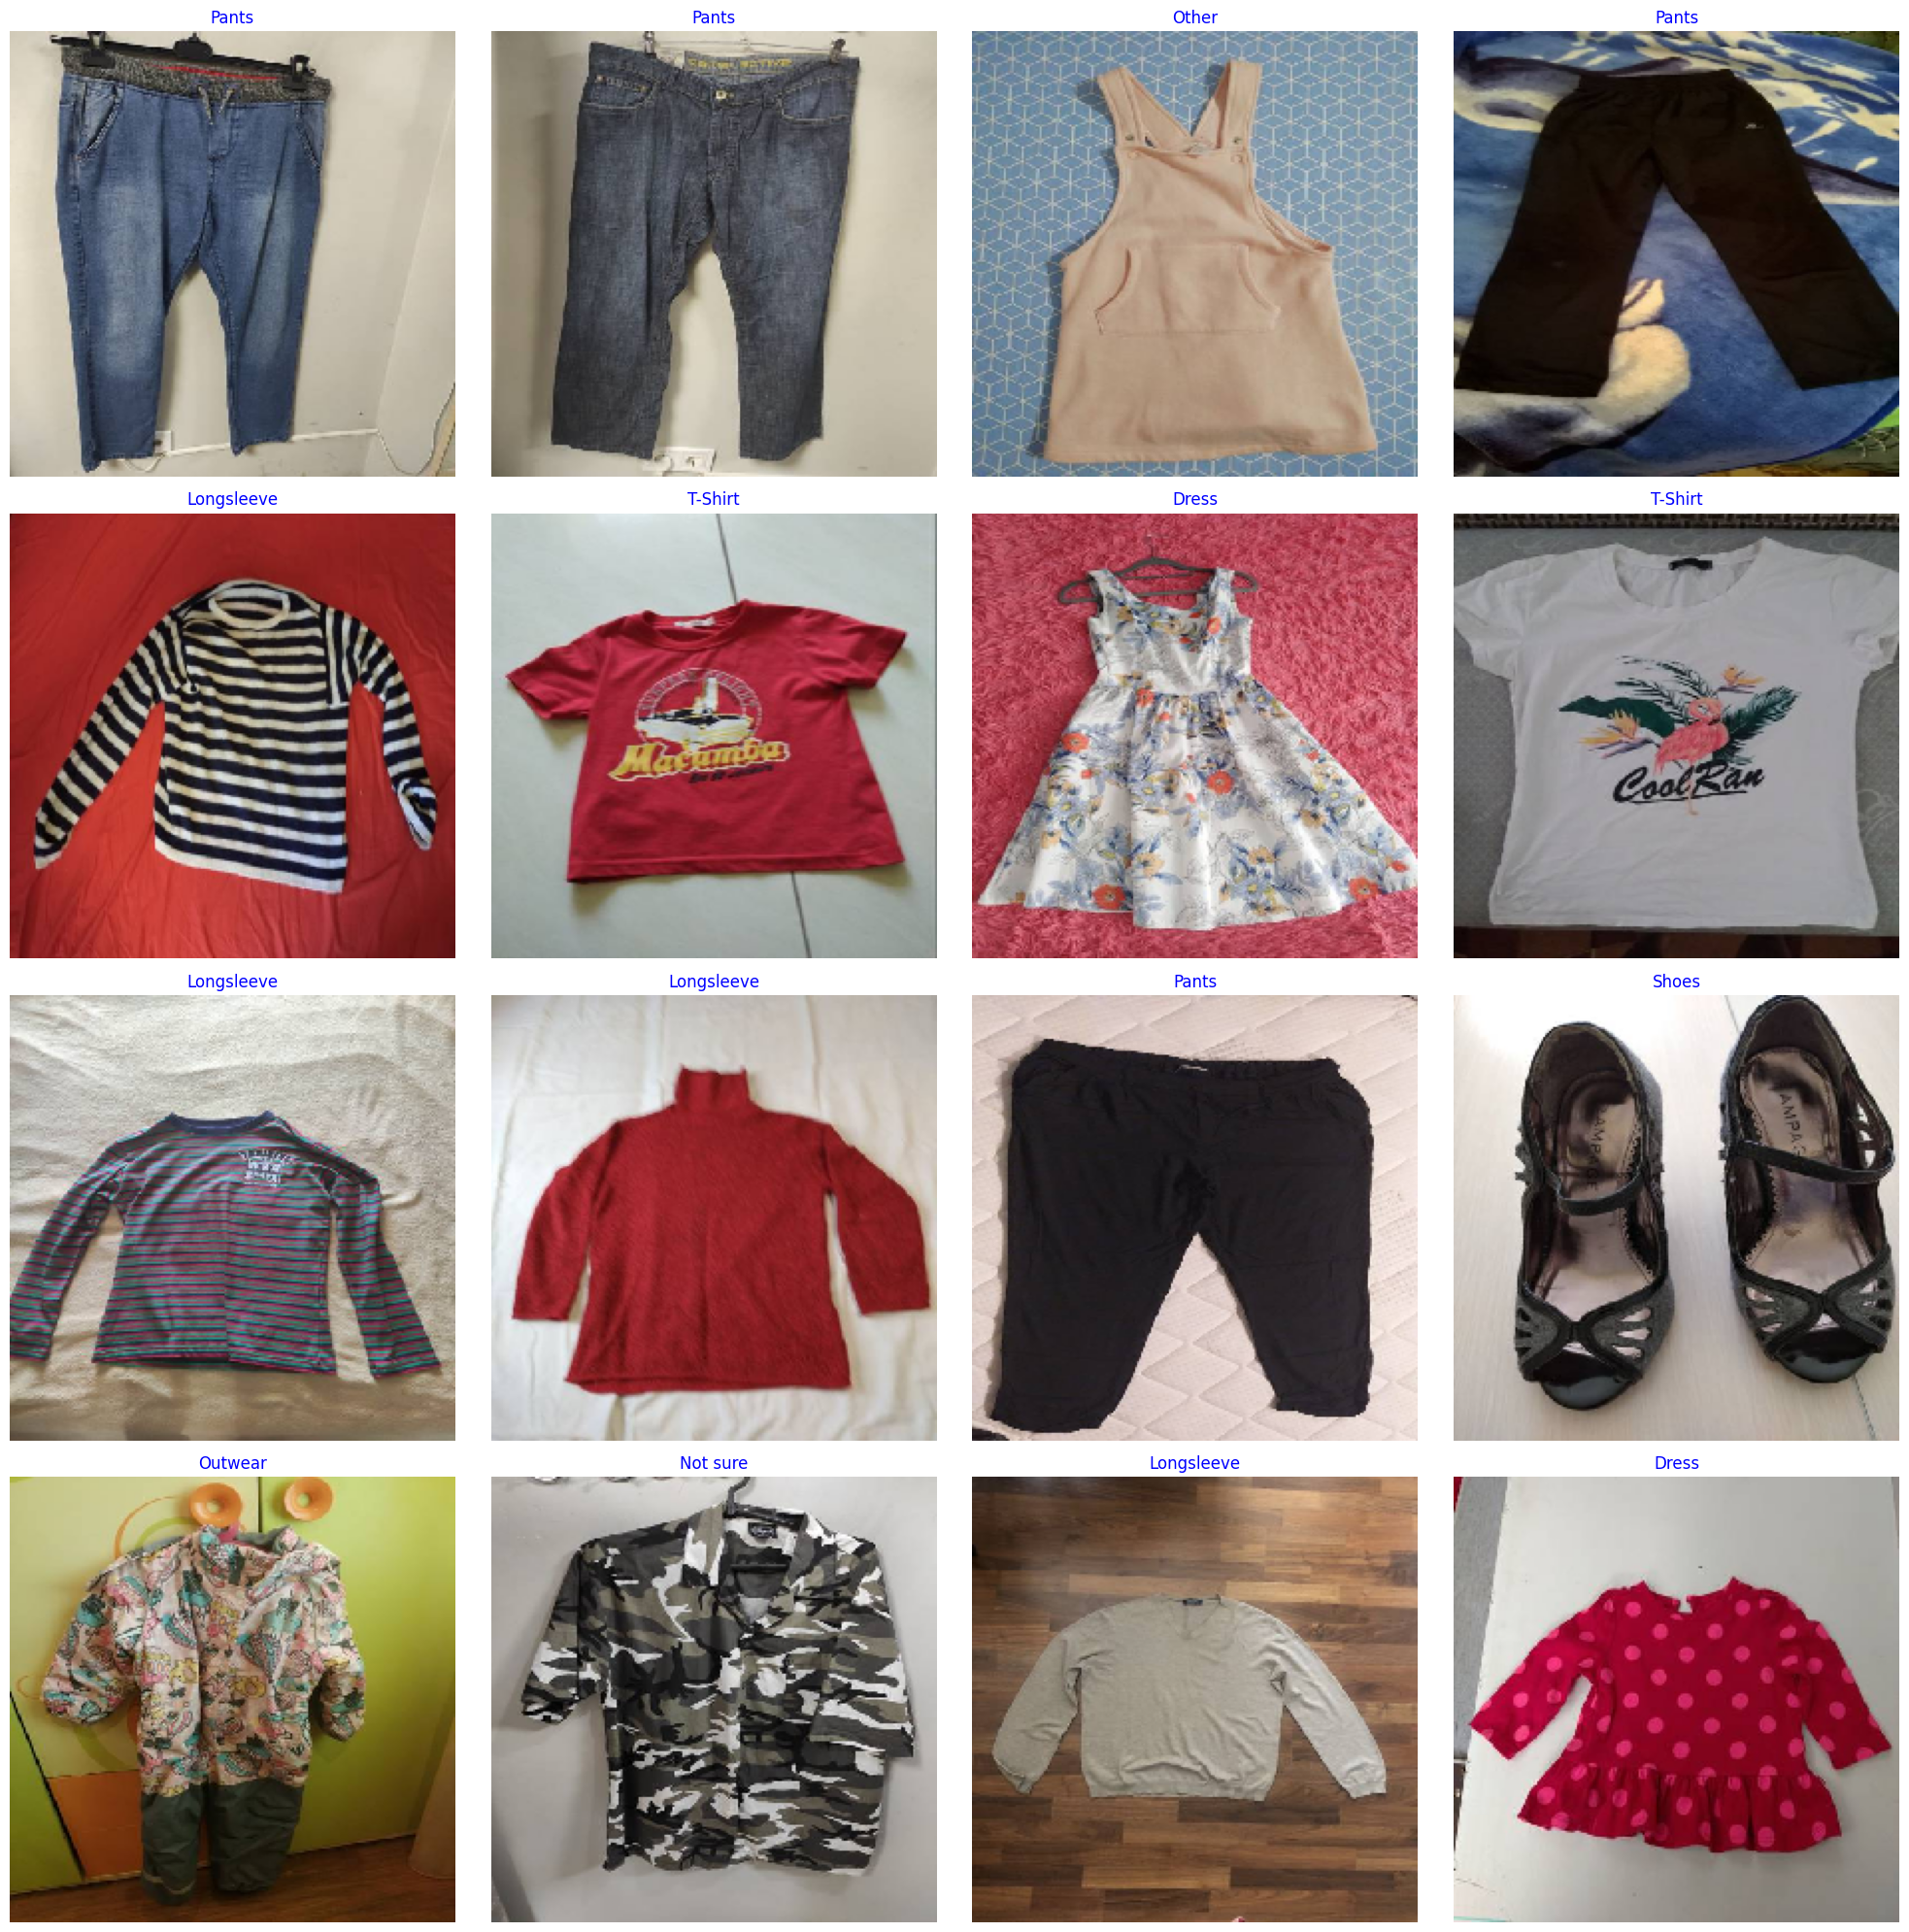

In [10]:
gen_dict = train_generator.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i].squeeze()
    plt.imshow(image) 
    index = np.argmax(labels[i]) 
    class_name = classes_name[index]  
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')


plt.tight_layout()
plt.show()

## **Modeling**

### Basic CNN Model

In [11]:
NAME = f"clothing-dataset-basic-cnn-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

basic_cnn = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)

basic_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

basic_cnn.summary()

Model: "clothing-dataset-basic-cnn-1717405545"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 222, 222, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         

 )                                                               

                                                                 

 flatten (Flatten)           (None, 394272)            0         

                                                                 

 dense (Dense)               (None, 19)                7491187   

                                                                 


Total params: 7,492,083

Trainable params: 7,492,083

Non-trainable params: 0

_________________________________________________________________


In [12]:
history_basic_cnn = basic_cnn.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/5

135/135 [==============================] - 11s 65ms/step - loss: 5.3934 - accuracy: 0.2777 - val_loss: 2.3007 - val_accuracy: 0.4045

Epoch 2/5

135/135 [==============================] - 8s 56ms/step - loss: 1.4250 - accuracy: 0.6159 - val_loss: 2.1193 - val_accuracy: 0.4545

Epoch 3/5

135/135 [==============================] - 8s 57ms/step - loss: 0.5457 - accuracy: 0.8759 - val_loss: 2.2333 - val_accuracy: 0.4601

Epoch 4/5

135/135 [==============================] - 8s 56ms/step - loss: 0.1827 - accuracy: 0.9668 - val_loss: 2.8369 - val_accuracy: 0.4304

Epoch 5/5

135/135 [==============================] - 8s 60ms/step - loss: 0.0726 - accuracy: 0.9944 - val_loss: 2.9451 - val_accuracy: 0.4675


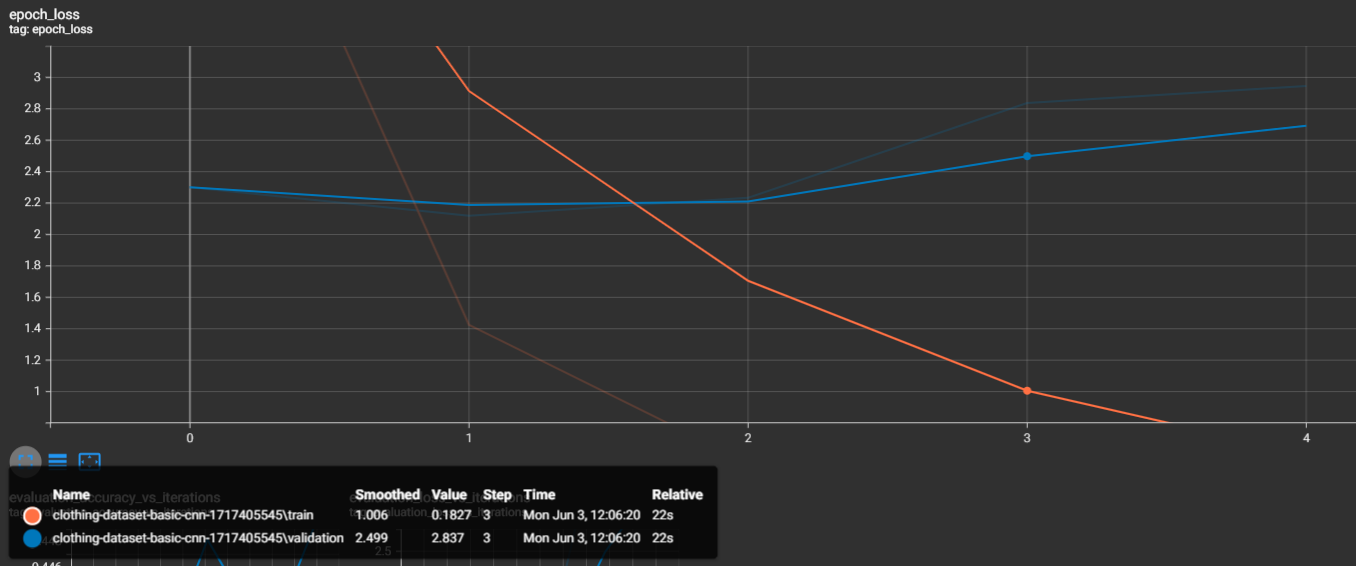

#### Спробуємо різні значення для padding, strides та kernel_size:

In [13]:
def f(ab):
    output = ""

    for ii in ab:
        output += str(ii)

    return output

In [14]:
def create_model(kernel_size, strides, padding):
    model = tf.keras.Sequential(
        layers=[
            tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
            
            tf.keras.layers.Conv2D(32, kernel_size, strides=strides, padding=padding, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
        ]
    )

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [15]:
# Create and train models with different parameters
kernel_sizes = [(3, 3), (5, 5)]
strides = [(1, 1), (2, 2), (3, 3)]
paddings = ['valid', 'same']

for kernel_size in kernel_sizes:
    for stride in strides:
        for padding in paddings:
            print(f'Kernel size: {kernel_size}, Stride: {stride}, Padding: {padding}')
            
            model = create_model(kernel_size, stride, padding)
            history = model.fit(
                train_generator,
                epochs=5, 
                validation_data=validation_generator,
                verbose=2
                )
            
            print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
            print("\n"*3)

Kernel size: (3, 3), Stride: (1, 1), Padding: valid

Epoch 1/5

135/135 - 8s - loss: 5.5702 - accuracy: 0.2733 - val_loss: 2.2492 - val_accuracy: 0.3803 - 8s/epoch - 63ms/step

Epoch 2/5

135/135 - 8s - loss: 1.3534 - accuracy: 0.6277 - val_loss: 2.3043 - val_accuracy: 0.4341 - 8s/epoch - 62ms/step

Epoch 3/5

135/135 - 8s - loss: 0.4767 - accuracy: 0.8903 - val_loss: 2.5424 - val_accuracy: 0.4453 - 8s/epoch - 61ms/step

Epoch 4/5

135/135 - 8s - loss: 0.1648 - accuracy: 0.9736 - val_loss: 3.3985 - val_accuracy: 0.4490 - 8s/epoch - 61ms/step

Epoch 5/5

135/135 - 8s - loss: 0.0671 - accuracy: 0.9912 - val_loss: 3.2010 - val_accuracy: 0.4564 - 8s/epoch - 59ms/step

Validation accuracy: 0.4564007520675659









Kernel size: (3, 3), Stride: (1, 1), Padding: same

Epoch 1/5

135/135 - 9s - loss: 6.0120 - accuracy: 0.2225 - val_loss: 2.4672 - val_accuracy: 0.3191 - 9s/epoch - 70ms/step

Epoch 2/5

135/135 - 8s - loss: 1.6948 - accuracy: 0.5198 - val_loss: 2.1668 - val_accuracy: 0.4286 - 

Значення доволі близькі і робити остаточний вибір зарано (робив вже експерименти, нічого хорошого не вийшло). Тим паче, спостерігаємо доволі слабку генерлізацію, можна говорити про перенавчання, а великі розміри ядра та страйдів можуть грати роль регуляризатора, звідси і відповідні значення.

In [16]:
kernel_size, strides, padding = (3, 3), (2, 2), "valid"

### Regularization Techniques
Додамо dropout та early stopping:

In [17]:
NAME = f"clothing-dataset-reg-cnn-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

reg_cnn = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)

reg_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_reg_cnn = reg_cnn.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[tensorboard, early_stopping]
)

Epoch 1/5

135/135 [==============================] - 8s 57ms/step - loss: 3.2184 - accuracy: 0.2684 - val_loss: 2.2130 - val_accuracy: 0.3970

Epoch 2/5

135/135 [==============================] - 8s 59ms/step - loss: 1.8683 - accuracy: 0.4681 - val_loss: 1.9871 - val_accuracy: 0.4416

Epoch 3/5

135/135 [==============================] - 8s 61ms/step - loss: 1.3828 - accuracy: 0.6006 - val_loss: 1.9288 - val_accuracy: 0.4564

Epoch 4/5

135/135 [==============================] - 8s 59ms/step - loss: 0.9487 - accuracy: 0.7444 - val_loss: 1.9319 - val_accuracy: 0.5009

Epoch 5/5

135/135 [==============================] - 9s 63ms/step - loss: 0.6219 - accuracy: 0.8513 - val_loss: 2.0379 - val_accuracy: 0.5009


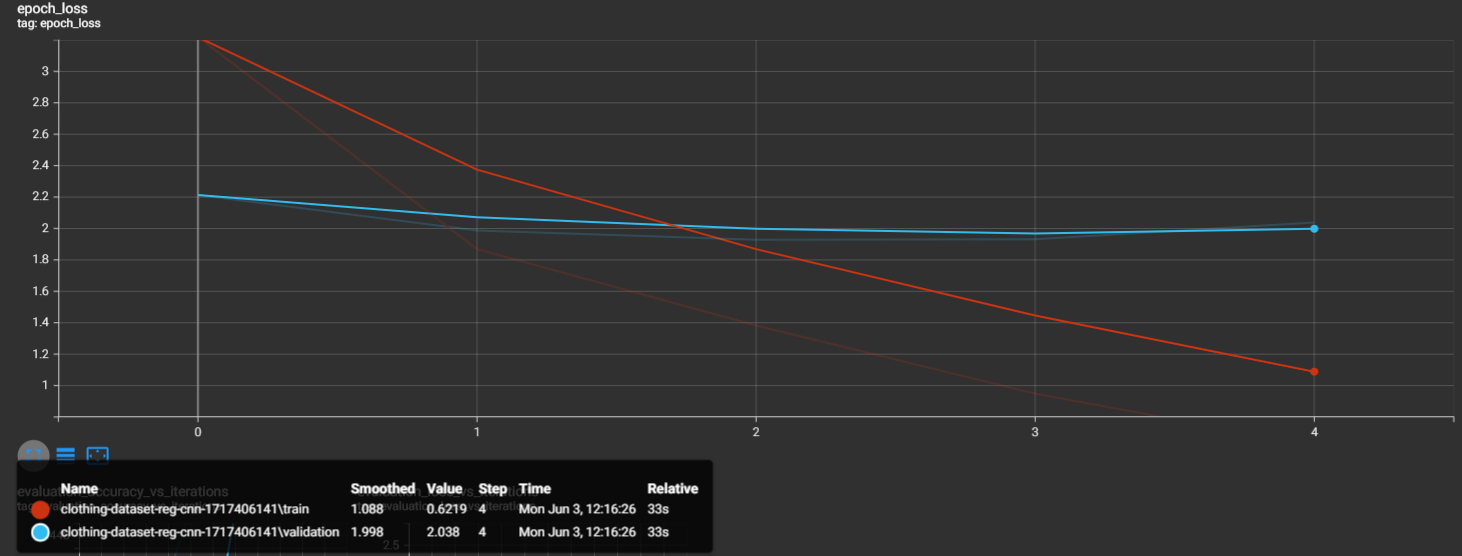

Трохи краще, проте все ще можемо спостерігати перенавчання.

### Data augmentation

In [19]:
train_generator_augmentation_strict = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_augmentation_weak = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,  # Reduced from 40
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1,  # Reduced from 0.2
    shear_range=0.1,  # Reduced from 0.2
    zoom_range=0.1,  # Reduced from 0.2
    horizontal_flip=True,  # Same
    fill_mode='nearest'  # Same
)


train_generator_augmentation_strict = train_generator_augmentation_strict.flow_from_dataframe(
    train_df, 
    x_col='filepath',
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

train_generator_augmentation_weak = train_generator_augmentation_weak.flow_from_dataframe(
    train_df, 
    x_col='filepath',
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

Found 4311 validated image filenames belonging to 19 classes.

Found 4311 validated image filenames belonging to 19 classes.


In [20]:
NAME = f"clothing-dataset-basic-cnn-augmented-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

basic_cnn_augmented = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)

basic_cnn_augmented.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history_basic_cnn_augmented = basic_cnn_augmented.fit(
    train_generator_augmentation_strict,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/5

135/135 [==============================] - 42s 309ms/step - loss: 3.0291 - accuracy: 0.1763 - val_loss: 2.5078 - val_accuracy: 0.2393

Epoch 2/5

135/135 [==============================] - 41s 302ms/step - loss: 2.5154 - accuracy: 0.2085 - val_loss: 2.4467 - val_accuracy: 0.2616

Epoch 3/5

135/135 [==============================] - 40s 295ms/step - loss: 2.4820 - accuracy: 0.2280 - val_loss: 2.4561 - val_accuracy: 0.2783

Epoch 4/5

135/135 [==============================] - 41s 302ms/step - loss: 2.4524 - accuracy: 0.2315 - val_loss: 2.4347 - val_accuracy: 0.3117

Epoch 5/5

135/135 [==============================] - 41s 303ms/step - loss: 2.4350 - accuracy: 0.2510 - val_loss: 2.4012 - val_accuracy: 0.2894


Фінально перемогли перенавчання, проте значно втратили точність. В подальших експериментах, напевно, віддамо перевагу `train_generator_augmentation_weak` та спробуємо побудувати щось більш цікаве з точки зору архітектури мережі.

### Explore Advanced Architectures

In [22]:
NAMES = [f"clothing-dataset-multi-conv-layers-cnn-{int(time.time())}",
         f"clothing-dataset-batch-normalization-cnn-{int(time.time())}",
         f"clothing-dataset-dropuot-cnn-{int(time.time())}"
        ]

In [23]:
# Multiple convolutional layers
model1 = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAMES[0]
)
model1.summary()
print("\n"*3)


# Batch normalization layers
model2 = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAMES[1]
)
model2.summary()
print("\n"*3)


# Dropout layers
model3 = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAMES[2]
)
model3.summary()

Model: "clothing-dataset-multi-conv-layers-cnn-1717406406"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_15 (Conv2D)          (None, 111, 111, 32)      896       

                                                                 

 max_pooling2d_15 (MaxPoolin  (None, 55, 55, 32)       0         

 g2D)                                                            

                                                                 

 conv2d_16 (Conv2D)          (None, 27, 27, 64)        18496     

                                                                 

 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 64)       0         

 g2D)                                                            

                                                                 

 flatten_15 (Flatten)        (None, 10816)             0         

                                                                 

 

In [24]:
for ii, model in enumerate([model1, model2, model3]):
    print(f'Model = {NAMES[ii]}')
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )
    
    history = model.fit(
        train_generator_augmentation_weak,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[tensorboard]
    )

    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
    print("\n"*3)

Model = clothing-dataset-multi-conv-layers-cnn-1717406406

Epoch 1/5

135/135 [==============================] - 44s 320ms/step - loss: 2.5227 - accuracy: 0.2262 - val_loss: 2.3021 - val_accuracy: 0.3265

Epoch 2/5

135/135 [==============================] - 45s 334ms/step - loss: 2.2253 - accuracy: 0.3466 - val_loss: 1.9700 - val_accuracy: 0.4471

Epoch 3/5

135/135 [==============================] - 45s 330ms/step - loss: 1.9955 - accuracy: 0.4254 - val_loss: 1.8718 - val_accuracy: 0.4972

Epoch 4/5

135/135 [==============================] - 44s 323ms/step - loss: 1.9026 - accuracy: 0.4479 - val_loss: 1.7723 - val_accuracy: 0.5232

Epoch 5/5

135/135 [==============================] - 44s 328ms/step - loss: 1.8222 - accuracy: 0.4693 - val_loss: 1.6919 - val_accuracy: 0.5343

Validation accuracy: 0.5343227982521057









Model = clothing-dataset-batch-normalization-cnn-1717406406

Epoch 1/5

135/135 [==============================] - 43s 317ms/step - loss: 4.1988 - accuracy: 0.228

Поки, результати моделі без Batch Normalization та Dropout мені подобаються найбільше. Зробимо ще по 5 епох навчання, аби остаточно обрати переможця.

In [25]:
for ii, model in enumerate([model1, model2, model3]):
    print(f'Model = {NAMES[ii]}')
    
    history = model.fit(
        train_generator_augmentation_weak,
        initial_epoch=5, epochs=10,
        validation_data=validation_generator,
        callbacks=[tensorboards[ii]]
    )

    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
    print("\n"*3)

Model = clothing-dataset-multi-conv-layers-cnn-1717406406

Epoch 6/10

135/135 [==============================] - 41s 300ms/step - loss: 1.7572 - accuracy: 0.4890 - val_loss: 1.6495 - val_accuracy: 0.5473

Epoch 7/10

135/135 [==============================] - 39s 288ms/step - loss: 1.7230 - accuracy: 0.4892 - val_loss: 1.6043 - val_accuracy: 0.5529

Epoch 8/10

135/135 [==============================] - 39s 289ms/step - loss: 1.6794 - accuracy: 0.5057 - val_loss: 1.5626 - val_accuracy: 0.5566

Epoch 9/10

135/135 [==============================] - 39s 290ms/step - loss: 1.6186 - accuracy: 0.5173 - val_loss: 1.4651 - val_accuracy: 0.5807

Epoch 10/10

135/135 [==============================] - 39s 291ms/step - loss: 1.5983 - accuracy: 0.5307 - val_loss: 1.5210 - val_accuracy: 0.5918

Validation accuracy: 0.5918367505073547









Model = clothing-dataset-batch-normalization-cnn-1717406406

Epoch 6/10

135/135 [==============================] - 41s 302ms/step - loss: 2.2570 - accuracy

Вибір таки падає на модель без Batch Normalization та Dropout. Побудуємо більш комплексну архітектуру додавши декілька Conv та Dense шарів.

In [27]:
NAME = f"clothing-dataset-4c-1d-cnn-augmented-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

c4_d1_cnn = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(256, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        # tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)

c4_d1_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c4_d1_cnn.summary()

Model: "clothing-dataset-4c-1d-cnn-augmented-1717407818"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_25 (Conv2D)          (None, 111, 111, 32)      896       

                                                                 

 max_pooling2d_25 (MaxPoolin  (None, 55, 55, 32)       0         

 g2D)                                                            

                                                                 

 conv2d_26 (Conv2D)          (None, 27, 27, 64)        18496     

                                                                 

 max_pooling2d_26 (MaxPoolin  (None, 13, 13, 64)       0         

 g2D)                                                            

                                                                 

 conv2d_27 (Conv2D)          (None, 6, 6, 128)         73856     

                                                                 

 ma

In [28]:
c4_d1_cnn_history = c4_d1_cnn.fit(
    train_generator_augmentation_weak,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10

135/135 [==============================] - 39s 285ms/step - loss: 2.5267 - accuracy: 0.2211 - val_loss: 2.2451 - val_accuracy: 0.3432

Epoch 2/10

135/135 [==============================] - 38s 282ms/step - loss: 2.1602 - accuracy: 0.3614 - val_loss: 2.0453 - val_accuracy: 0.3915

Epoch 3/10

135/135 [==============================] - 39s 292ms/step - loss: 1.9384 - accuracy: 0.4282 - val_loss: 1.7648 - val_accuracy: 0.5139

Epoch 4/10

135/135 [==============================] - 40s 296ms/step - loss: 1.7950 - accuracy: 0.4660 - val_loss: 1.6798 - val_accuracy: 0.5176

Epoch 5/10

135/135 [==============================] - 43s 318ms/step - loss: 1.6955 - accuracy: 0.4932 - val_loss: 1.6149 - val_accuracy: 0.5362

Epoch 6/10

135/135 [==============================] - 40s 291ms/step - loss: 1.6201 - accuracy: 0.5159 - val_loss: 1.4488 - val_accuracy: 0.6141

Epoch 7/10

135/135 [==============================] - 40s 297ms/step - loss: 1.5648 - accuracy: 0.5307 - val_loss: 1.

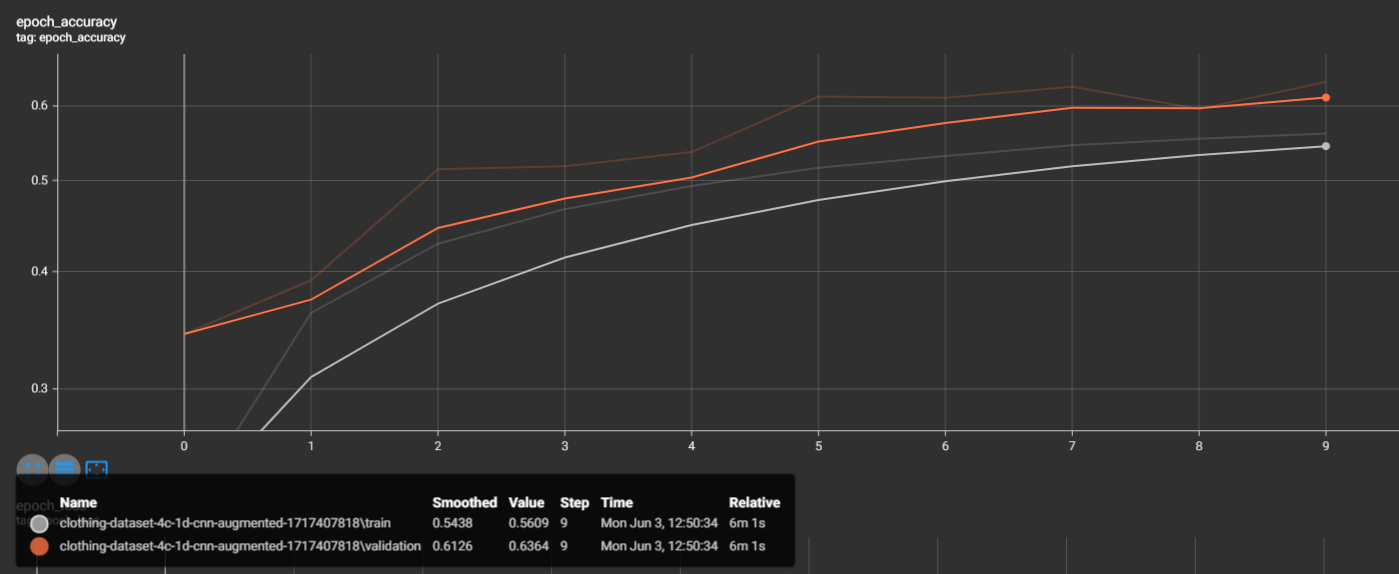
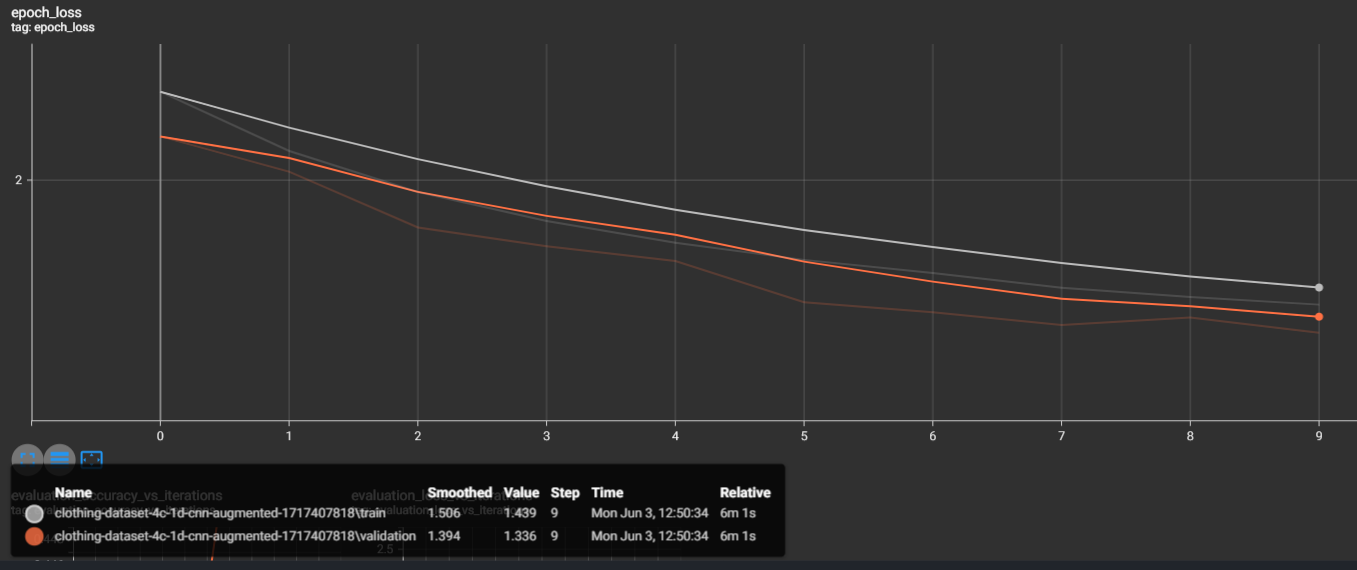

Виглядає непогано, проте через низький скор на трейні можна зробити припущення про складність моделлю ловити патерни. Спробуємо додати Dense шарів та збільшити кількість епох.

In [30]:
NAME = f"clothing-dataset-4c-3d-cnn-augmented-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

c4_d3_cnn = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        
        tf.keras.layers.Conv2D(32, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(256, kernel_size=kernel_size, strides=strides, padding=padding, activation='relu'),
        # tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),

        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)


c4_d3_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

c4_d3_cnn.summary()

Model: "clothing-dataset-4c-3d-cnn-augmented-1717408282"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_33 (Conv2D)          (None, 111, 111, 32)      896       

                                                                 

 max_pooling2d_31 (MaxPoolin  (None, 55, 55, 32)       0         

 g2D)                                                            

                                                                 

 conv2d_34 (Conv2D)          (None, 27, 27, 64)        18496     

                                                                 

 max_pooling2d_32 (MaxPoolin  (None, 13, 13, 64)       0         

 g2D)                                                            

                                                                 

 conv2d_35 (Conv2D)          (None, 6, 6, 128)         73856     

                                                                 

 ma

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_c4_d3_cnn = c4_d3_cnn.fit(
    train_generator_augmentation_weak,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tensorboard, early_stopping]
)

Epoch 1/30

135/135 [==============================] - 42s 310ms/step - loss: 2.6427 - accuracy: 0.1714 - val_loss: 2.6060 - val_accuracy: 0.1874

Epoch 2/30

135/135 [==============================] - 46s 342ms/step - loss: 2.5634 - accuracy: 0.2069 - val_loss: 2.4138 - val_accuracy: 0.2839

Epoch 3/30

135/135 [==============================] - 45s 331ms/step - loss: 2.3622 - accuracy: 0.2911 - val_loss: 2.1973 - val_accuracy: 0.3803

Epoch 4/30

135/135 [==============================] - 42s 307ms/step - loss: 2.1781 - accuracy: 0.3510 - val_loss: 2.0710 - val_accuracy: 0.3896

Epoch 5/30

135/135 [==============================] - 41s 301ms/step - loss: 2.0605 - accuracy: 0.3902 - val_loss: 1.9372 - val_accuracy: 0.4416

Epoch 6/30

135/135 [==============================] - 41s 301ms/step - loss: 1.9285 - accuracy: 0.4301 - val_loss: 1.7904 - val_accuracy: 0.4694

Epoch 7/30

135/135 [==============================] - 46s 340ms/step - loss: 1.8663 - accuracy: 0.4456 - val_loss: 1.

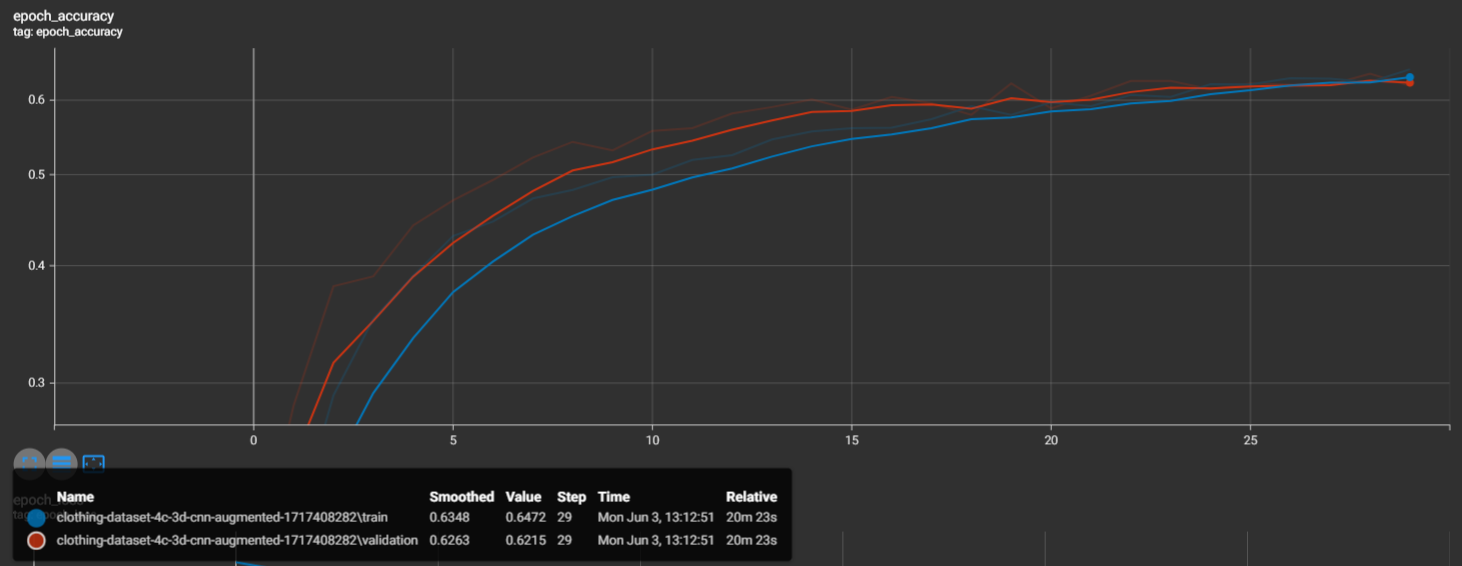
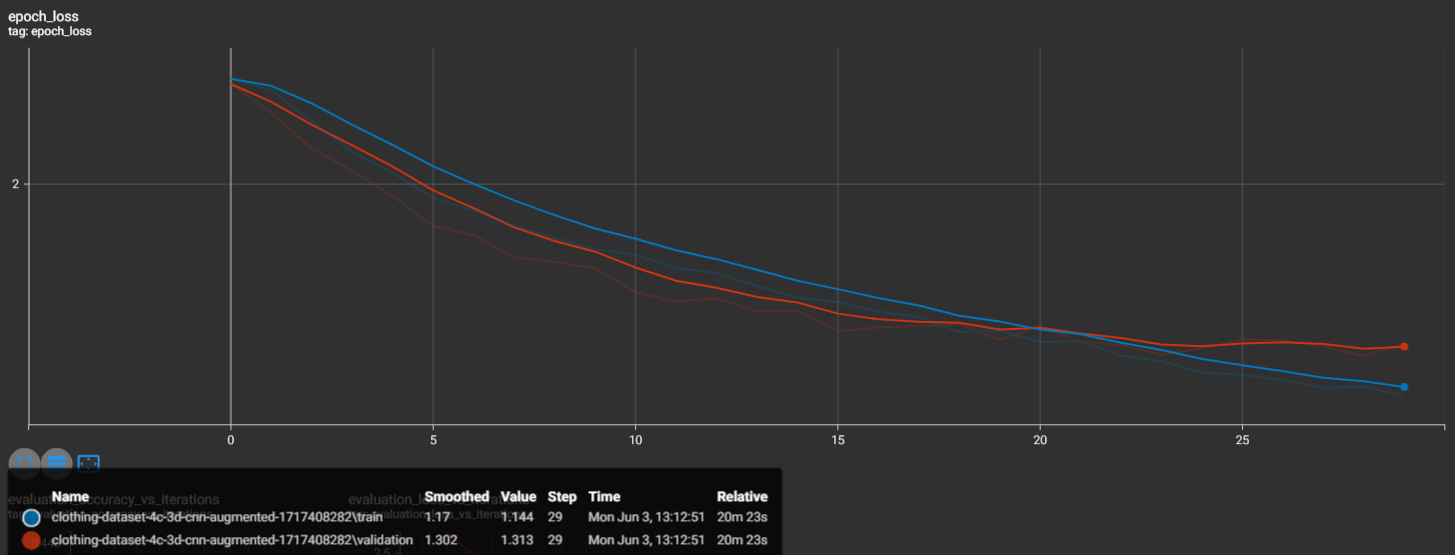

### Evaluation

In [39]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = c4_d3_cnn.evaluate(train_generator_augmentation_weak, steps= test_steps, verbose= 1)
valid_score = c4_d3_cnn.evaluate(validation_generator, steps= test_steps, verbose= 1)
test_score = c4_d3_cnn.evaluate(test_generator, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 [==============================] - 3s 273ms/step - loss: 1.0907 - accuracy: 0.6597

9/9 [==============================] - 1s 49ms/step - loss: 1.3445 - accuracy: 0.6285

9/9 [==============================] - 1s 130ms/step - loss: 1.1902 - accuracy: 0.6215

Train Loss:  1.0907020568847656

Train Accuracy:  0.6597222089767456

--------------------

Valid Loss:  1.3444623947143555

Valid Accuracy:  0.6284722089767456

--------------------

Test Loss:  1.1901931762695312

Test Accuracy:  0.6215277910232544


Результати більш-менш непогані.

Порівняємо з MLP, будемо використовувати доповнений набір для трейну.

## MLP Model

In [41]:
NAME = f"handwritten-az-mlp-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

mlp = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(100, activation='relu'),

        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')        
    ],
    name=NAME
)

mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mlp.summary()

Model: "handwritten-az-mlp-1717411227"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 flatten_25 (Flatten)        (None, 150528)            0         

                                                                 

 dense_40 (Dense)            (None, 200)               30105800  

                                                                 

 dense_41 (Dense)            (None, 100)               20100     

                                                                 

 dense_42 (Dense)            (None, 19)                1919      

                                                                 


Total params: 30,127,819

Trainable params: 30,127,819

Non-trainable params: 0

_________________________________________________________________


In [42]:
mlp_history = mlp.fit(
    train_generator_augmentation_weak,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10

135/135 [==============================] - 40s 294ms/step - loss: 19.7991 - accuracy: 0.1387 - val_loss: 3.7366 - val_accuracy: 0.3061

Epoch 2/10

135/135 [==============================] - 40s 296ms/step - loss: 4.3535 - accuracy: 0.1707 - val_loss: 4.4973 - val_accuracy: 0.2208

Epoch 3/10

135/135 [==============================] - 42s 308ms/step - loss: 3.3057 - accuracy: 0.1682 - val_loss: 2.8139 - val_accuracy: 0.1317

Epoch 4/10

135/135 [==============================] - 42s 308ms/step - loss: 2.8394 - accuracy: 0.1371 - val_loss: 2.7436 - val_accuracy: 0.1336

Epoch 5/10

135/135 [==============================] - 40s 296ms/step - loss: 2.8250 - accuracy: 0.1844 - val_loss: 2.6151 - val_accuracy: 0.1503

Epoch 6/10

135/135 [==============================] - 40s 299ms/step - loss: 2.6890 - accuracy: 0.2118 - val_loss: 2.6902 - val_accuracy: 0.2412

Epoch 7/10

135/135 [==============================] - 42s 311ms/step - loss: 2.6978 - accuracy: 0.2155 - val_loss: 2

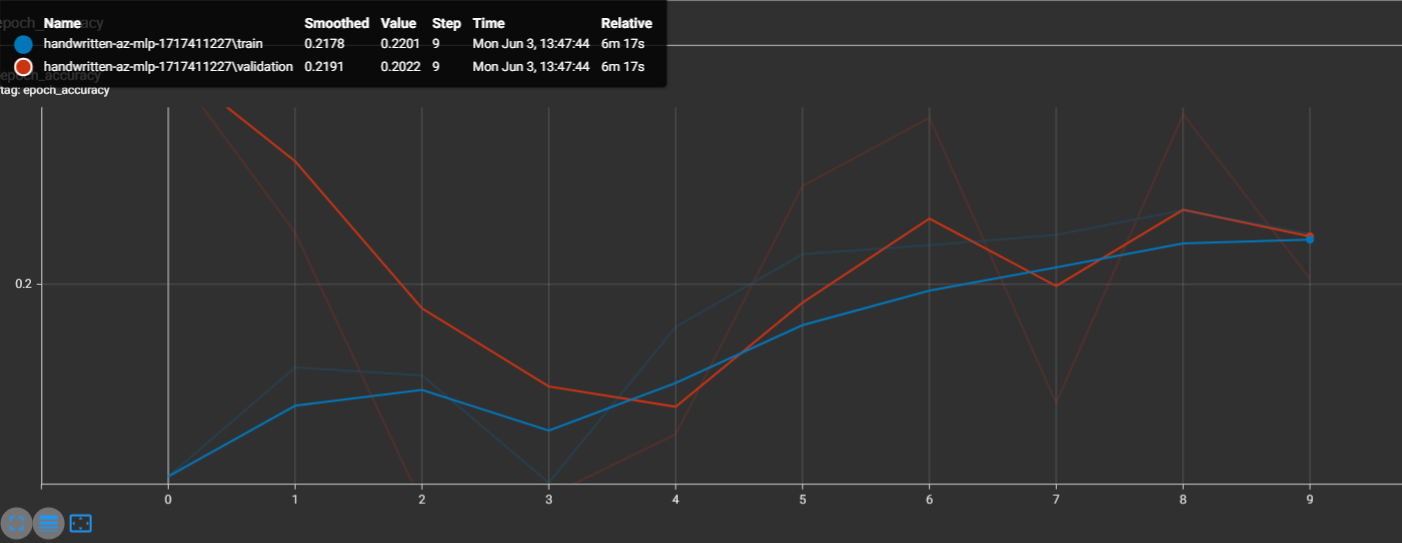
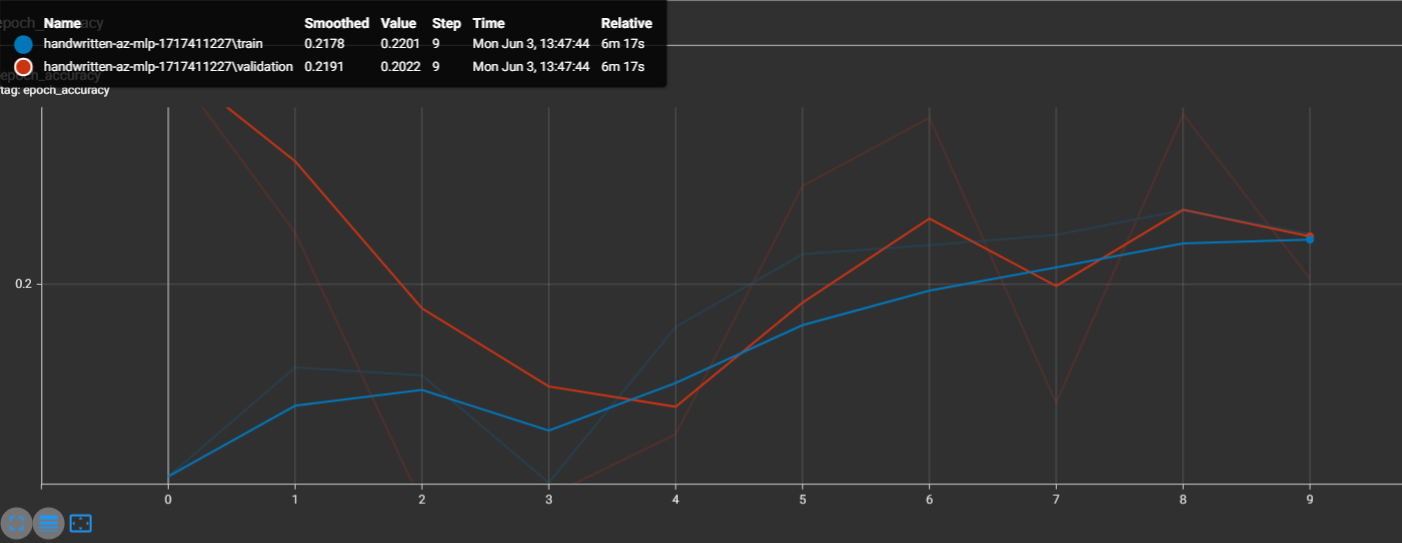